# Title- Object Detection using Yolo & CNN

pygame 2.5.2 (SDL 2.28.3, Python 3.11.5)
Hello from the pygame community. https://www.pygame.org/contribute.html



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pooja\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!




1/1 [==============================] - 3s 3s/step
Detected Object: person
1/1 [==============================] - 0s 57ms/step
Detected Object: person
1/1 [==============================] - 0s 55ms/step
Detected Object: person
1/1 [==============================] - 0s 58ms/step
Detected Object: person
1/1 [==============================] - 0s 56ms/step
Detected Object: person
1/1 [==============================] - 0s 67ms/step
Detected Object: person
1/1 [==============================] - 0s 52ms/step
Detected Object: person
1/1 [==============================] - 0s 50ms/step
Detected Object: person
1/1 [==============================] - 0s 46ms/step
Detected Object: person
1/1 [==============================] - 0s 47ms/step
Detected Object: person
1/1 [==============================] - 0s 65ms/step
Detected Object: person
Average BLEU Score: 0.19180183554164507


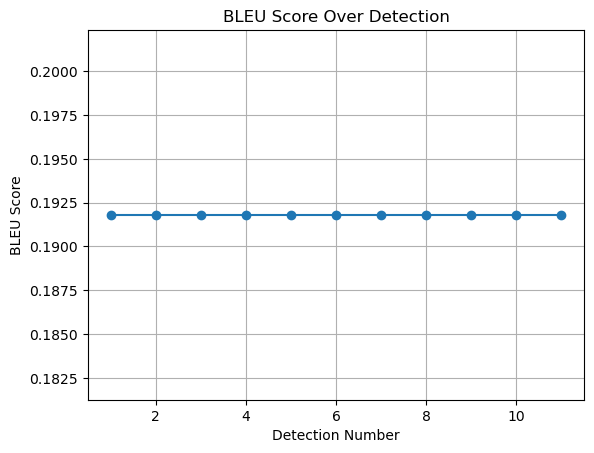

In [1]:
import numpy as np
import cv2
from gtts import gTTS
import os
import pygame
import tempfile
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt

# Initialize NLTK
nltk.download('punkt')

# Initialize pygame
pygame.init()

# Define the paths to the weights and configuration files
labels_path = 'C:\\Users\\pooja\\OneDrive\\Desktop\\hello\\coco.names'
weights_path = "C:\\Users\\pooja\\OneDrive\\Desktop\\hello\\yolov3.weights"
configuration_path = "C:\\Users\\pooja\\OneDrive\\Desktop\\hello\\yolov3.cfg"

# Load the labels
labels = open(labels_path).read().strip().split('\n')

network = cv2.dnn.readNetFromDarknet(configuration_path, weights_path)
cnn_model = MobileNetV2(weights='imagenet')

# Open the camera (use 0 for the default camera)
cap = cv2.VideoCapture(0)

frame_width = 640
frame_height = 480
frame_delay = 10  # Adjust this value for faster playback

# Initialize lists to store system-generated descriptions and human-generated reference translations
system_descriptions = []
reference_translations = []
bleu_scores = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    h, w, _ = frame.shape

    blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416), swapRB=True, crop=False)

    network.setInput(blob)

    layers_names_output = network.getUnconnectedOutLayersNames()
    output_from_network = network.forward(layers_names_output)

    detected_objects = set()
    bounding_boxes = []
    confidences = []
    class_numbers = []

    for result in output_from_network:
        for detection in result:
            scores = detection[5:]
            class_current = np.argmax(scores)
            confidence_current = scores[class_current]

            if confidence_current > 0.5:
                box_current = detection[0:4] * np.array([w, h, w, h])
                x_center, y_center, box_width, box_height = box_current.astype('int')
                x_min = int(x_center - (box_width / 2))
                y_min = int(y_center - (box_height / 2))
                bounding_boxes.append((x_min, y_min, int(box_width), int(box_height)))
                confidences.append(float(confidence_current))
                class_numbers.append(class_current)

    results = cv2.dnn.NMSBoxes(bounding_boxes, confidences, 0.5, 0.4)

    if len(results) > 0:
        for i in results.flatten():
            x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
            box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]
            cv2.rectangle(frame, (x_min, y_min), (x_min + box_width, y_min + box_height), (0, 255, 0), 2)
            text_box_current = '{}: {:.4f}'.format(labels[class_numbers[i]], confidences[i])
            cv2.putText(frame, text_box_current, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

            object_label = labels[class_numbers[i]]
            detected_objects.add(object_label)

            img_for_cnn = frame[y_min:y_min + box_height, x_min:x_min + box_width]

            # Ensure img_for_cnn is not empty
            if img_for_cnn.size == 0:
                continue

            # Resize image for CNN
            img_for_cnn = cv2.resize(img_for_cnn, (224, 224))
            img_for_cnn = image.img_to_array(img_for_cnn)
            img_for_cnn = np.expand_dims(img_for_cnn, axis=0)
            img_for_cnn = preprocess_input(img_for_cnn)

            # Predict object using CNN
            cnn_prediction = cnn_model.predict(img_for_cnn)
            cnn_label = decode_predictions(cnn_prediction)
            cnn_label = cnn_label[0][0][1]

            # Print the name of the detected object
            print("Detected Object:", object_label)

            # Generate a system description for the detected object
            system_description = f"{cnn_label} {object_label}"  # Concatenate CNN label and object label
            system_descriptions.append(system_description)

            # Generate a human-generated reference translation for the detected object
            reference_translation = f"a {cnn_label} {object_label}"
            reference_translations.append(reference_translation)

            # Save the speech as a temporary audio file in the current directory
            temp_audio_file = 'temp.mp3'
            tts = gTTS(text=f"{object_label}", lang='en')
            tts.save(temp_audio_file)

            # Play the audio file using pygame mixer Sound object
            sound = pygame.mixer.Sound(temp_audio_file)
            sound.play()
            while pygame.mixer.get_busy():
                continue  # Wait for the audio to finish playing

            # Remove the temporary audio file
            os.remove(temp_audio_file)

    # Resize the frame to the desired dimensions
    frame = cv2.resize(frame, (frame_width, frame_height))
    cv2.imshow('Object Detection', frame)

    # Set the frame delay to control playback speed
    key = cv2.waitKey(frame_delay)

    if key == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Calculate BLEU score
smoothie = SmoothingFunction().method1

# Calculate BLEU score
total_bleu_score = 0
for system_desc, reference_translation in zip(system_descriptions, reference_translations):
    bleu_score = sentence_bleu([reference_translation.split()], system_desc.split(), smoothing_function=smoothie)
    total_bleu_score += bleu_score
    bleu_scores.append(bleu_score)

average_bleu_score = total_bleu_score / len(system_descriptions)
print("Average BLEU Score:", average_bleu_score)

# Plotting BLEU Score
plt.plot(range(1, len(bleu_scores) + 1), bleu_scores, marker='o', linestyle='-')
plt.xlabel('Detection Number')
plt.ylabel('BLEU Score')
plt.title('BLEU Score Over Detection')
plt.grid(True)
plt.show()
